# Joint Crab analysis 

Here we propose to redo the Crab joint analysis. We will start from already reduced datasets and add the HAWC release dataset.

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord

from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, PointSpatialModel, LogParabolaSpectralModel, SkyModel, GaussianPrior

Read the public Crab datasets from [Nigro et al. 2019](https://www.aanda.org/articles/aa/full_html/2019/05/aa34938-18/aa34938-18.html) available in `GAMMAPY_DATA`

In [2]:
instruments = ["fermi", "fact", "magic", "veritas", "hess"] 

path = Path(os.environ["GAMMAPY_DATA"])/ "joint-crab/spectra"

datasets = Datasets()

for instrument in instruments:
    files = list(path.rglob(f"{instrument}/pha_*.fits"))
    for filename in files:
        name=f"_{instrument}_{filename.stem.split('_')[-1]}"
        print(name)
        dataset = SpectrumDatasetOnOff.read(filename).copy(name=name)
        datasets.append(dataset)


_fermi_obs0
_fact_stacked
_magic_obs5029747
_magic_obs5029748
_veritas_obs54809
_veritas_obs57993
_hess_obs23559
_hess_obs23523
_hess_obs23592
_hess_obs23526


Read the HAWC datasets provided

In [3]:
filename = "./datasets/hawc_datasets/HAWC_pass4_public_Crab.yaml"
datasets_hawc = datasets.read(filename)
datasets_hawc = [d.copy(name="_hawc_"+d.name) for d in datasets_hawc]


/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/utils/scripts.py:71: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


add them to the list

In [4]:
datasets.extend(datasets_hawc)
instruments.append("hawc")

In [5]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : _fermi_obs0
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : _fact_stacked
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : _magic_obs5029747
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : _magic_obs5029748
  Instrument : 
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : _veritas_obs54809
  Instrument : 
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : _veritas_obs57993
  Instrument : 
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23559
  Instrument : 
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23523
  Instrument : 
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs2359

and write everything in our working directory

In [6]:
path = Path("./datasets/")
path.mkdir(exist_ok=True)

filename = path / "datasets_joint_crab_1d.yaml"
datasets.write(filename, overwrite=True)

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


In [7]:
crab_position = SkyCoord(83.6324, 22.0174, unit="deg", frame="icrs")

spatial_model = PointSpatialModel.from_position(crab_position)
spatial_model.freeze() # frozen for 1D analysis

# We directly start with a log parabola model
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2.,
    beta=0.,
    reference=1 * u.TeV,
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="crab")

models = Models([model])

### Setting the model and fitting

Here we define only the Crab model. All datasets from Fermi to HESS use ON-OFF statistic, they don't require explicit background models. The HAWC datasets all contain a background map. The latter is determined and constrained on a much larger scale. Correction factors are therefore non-necessary a priori.

In [8]:
datasets.models = [model]

In [9]:
optimize_opts = dict(strategy=1, tolerance=0.1)
fit = Fit(optimize_opts=optimize_opts)

### Performing fit per instruments

Here we want to perform a fit per instrument. In order to create a plot with all the butterfly plots we need valid ranges for the fits. We compute them looking at non empty bins in the non masked region of the dataset.

In [10]:
def get_instrument_datasets(datasets, instrument):
    return Datasets([d for d in datasets if instrument in d.name])

# there could be a more robust way to estimate this. e.g. consider bins with positive excess counts
def determine_valid_range(datasets):
    emin, emax = [], []
    for ds in datasets:
        idx = np.nonzero((ds.counts.data>0)*ds.mask.data)[0]
        idx_min, idx_max = np.min(idx), np.max(idx)
        
        emin.append(ds.counts.geom.axes["energy"].edges[idx_min])
        emax.append(ds.counts.geom.axes["energy"].edges[idx_max])
    return np.min(u.Quantity(emin)), np.max(u.Quantity(emax))        

In [11]:
results = []
for instrument in instruments:
    datasets_instrument = get_instrument_datasets(datasets, instrument)
    datasets_instrument.models = models
    fit_result = fit.run(datasets=datasets_instrument)
    emin, emax = determine_valid_range(datasets_instrument)
    
    result_dict = {}
    result_dict["instrument"] = instrument
    result_dict["fit_result"] = fit_result
    result_dict["emin"] = emin.to("TeV")
    result_dict["emax"] = emax.to("TeV")
    
    results.append(result_dict)

In [12]:
results

[{'instrument': 'fermi',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x157f66870>,
  'emin': <Quantity 0.03162278 TeV>,
  'emax': <Quantity 1.41253754 TeV>},
 {'instrument': 'fact',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x156fef620>,
  'emin': <Quantity 0.56234133 TeV>,
  'emax': <Quantity 15.84893192 TeV>},
 {'instrument': 'magic',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x157b27cb0>,
  'emin': <Quantity 0.07943282 TeV>,
  'emax': <Quantity 12.58925412 TeV>},
 {'instrument': 'veritas',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x156e3b530>,
  'emin': <Quantity 0.15848932 TeV>,
  'emax': <Quantity 28.18382931 TeV>},
 {'instrument': 'hess',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x156f38d40>,
  'emin': <Quantity 0.70794578 TeV>,
  'emax': <Quantity 70.79457844 TeV>},
 {'instrument': 'hawc',
  'fit_result': <gammapy.modeling.fit.FitResult at 0x1580281a0>,
  'emin': <Quantity 1. TeV>,
  'emax': <Quantity 100. TeV>}]

In [13]:
joint_results = fit.run(datasets)
result_dict = {}
result_dict["instrument"] = "joint"
result_dict["fit_result"] = joint_results
result_dict["emin"] = 10*u.GeV
result_dict["emax"] = 100*u.TeV
results.append(result_dict)


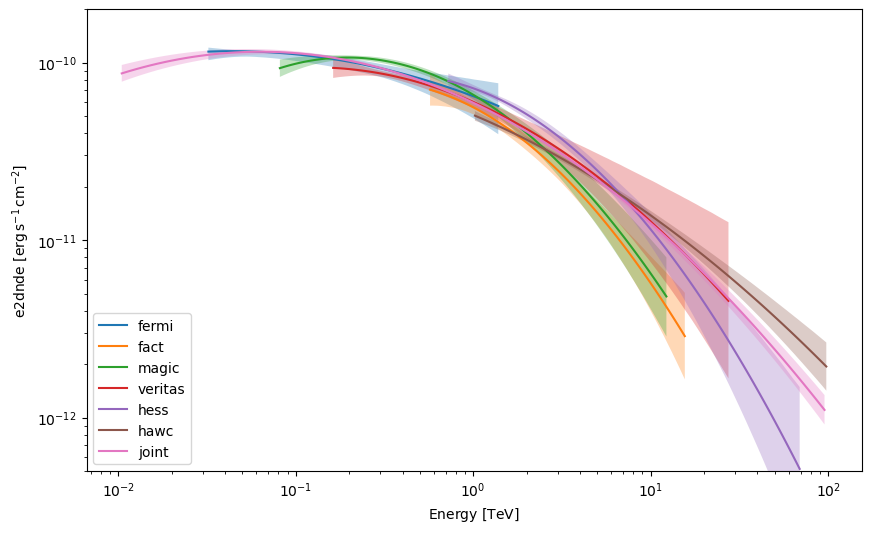

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

plot_kwargs = {
    "sed_type": "e2dnde",
    "ax": ax,
}
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for result, color in zip(results, colors):
    model = result["fit_result"].models["crab"]
    energy_bounds=u.Quantity([result["emin"], result["emax"]]).to("TeV")
    model.spectral_model.plot(energy_bounds,
        **plot_kwargs, label=result["instrument"], ls="-", color=color
    )
    model.spectral_model.plot_error(energy_bounds,
                                    facecolor=color, alpha=0.3, **plot_kwargs)
ax.set_ylim(5e-13, 2e-10)
ax.legend(loc=3)
plt.show()

### Taking into account inter-calibration systematics

In the following, we will assume that the largest effect is caused by uncertainties in the absolute energy scale.

Gammapy does not provide a simple way to model systematics uncertainties. We can create a simple modified log-parabola model to do it. We show how to do it below.

In [15]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel, SPECTRAL_MODEL_REGISTRY

class ScaledLogParabolaSpectralModel(SpectralModel):
    tag = "ScaledLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", scale_method="scale10", interp="log")
    reference = Parameter("reference", "10 TeV", frozen=True)
    alpha = Parameter("alpha", 2)
    beta = Parameter("beta", 1)
    bias = Parameter("bias", 1)

    @staticmethod
    def evaluate(energy, amplitude, reference, alpha, beta, bias):
        return LogParabolaSpectralModel.evaluate(energy*bias, amplitude, reference, alpha, beta)

    @classmethod
    def from_log_parabola(cls, lpl):
        return cls(amplitude=lpl.amplitude.quantity, 
            alpha=lpl.alpha.quantity,
            beta=lpl.beta.quantity,
            reference=lpl.reference.quantity)

SPECTRAL_MODEL_REGISTRY.append(ScaledLogParabolaSpectralModel)

In [16]:
parent_model = results[-1]["fit_result"].models["crab"].spectral_model
bias_lpl = ScaledLogParabolaSpectralModel.from_log_parabola(parent_model)

models = Models()
for instrument in instruments:
    names = [_.name for _ in get_instrument_datasets(datasets, instrument)]
    
    spec_model = bias_lpl.copy()
    
    # We add a prior of the bias with a reasonable a priori uncertainty
    spec_model.bias.prior = GaussianPrior(mu=1.0,sigma=0.05)
    
    models.append(SkyModel(spectral_model=spec_model, spatial_model=spatial_model , datasets_names=names, name=f"lpl_{instrument}"))


# sharing parameters
for model in models[1:]:
    model.spectral_model.amplitude = models[0].parameters["amplitude"]
    model.spectral_model.alpha = models[0].parameters["alpha"]
    model.spectral_model.beta = models[0].parameters["beta"]
    

In [17]:
datasets.models = models

In [20]:
res = fit.run(datasets)

In [21]:
res.models

Now we can even try to see if we can introduce a nuisance parameter per dataset. After all different runs might suffer from different atmospheric conditions. Different HAWC event types might also suffer from different systematics.

In [23]:
bias_lpl = ScaledLogParabolaSpectralModel.from_log_parabola(parent_model)

models = Models()
for dataset in datasets:
    spec_model = bias_lpl.copy()
    
    # We add a prior of the bias with a reasonable a priori uncertainty
    spec_model.bias.prior = GaussianPrior(mu=1.0,sigma=0.05)
    
    models.append(SkyModel(spectral_model=spec_model, spatial_model=spatial_model , datasets_names=dataset.name, name=f"lpl_{dataset.name}"))


# sharing parameters
for model in models[1:]:
    model.spectral_model.amplitude = models[0].parameters["amplitude"]
    model.spectral_model.alpha = models[0].parameters["alpha"]
    model.spectral_model.beta = models[0].parameters["beta"]


In [24]:
datasets.models = models

In [25]:
res = fit.run(datasets)

In [26]:
res.models

## Using nested sampling to explore parameters

We need to put priors on every parameter. We will add priors on the amplitude, alpha and beta parameters of the log parabola.

In [29]:
from gammapy.modeling.models import LogUniformPrior

models[0].spectral_model.alpha.prior = GaussianPrior(mu=2.5, sigma=0.2)
models[0].spectral_model.beta.prior = GaussianPrior(mu=0.1, sigma=0.15)
models[0].spectral_model.amplitude.prior = LogUniformPrior(min=3e-11, max=5e-11)

datasets.models = models

In [32]:
from gammapy.modeling import Sampler

sampler_opts = {
    "live_points": 300,
    "frac_remain": 0.3,
    "log_dir": None,
}

sampler = Sampler(backend="ultranest", sampler_opts=sampler_opts)
sample_results = sampler.run(datasets[:10])

[ultranest] Sampling 300 live points from prior ...


[ultranest] Explored until L=-2e+02  .55 [-227.8663..-227.8604]*| it/evals=4437/140917 eff=3.1554% N=300 
[ultranest] Likelihood function evaluations: 140917
[ultranest]   logZ = -240.7 +- 0.1571
[ultranest] Effective samples strategy satisfied (ESS = 1353.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.31, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.26 total:0.31 required:<0.50
[ultranest] done iterating.

logZ = -240.692 +- 0.461
  single instance: logZ = -240.692 +- 0.188
  bootstrapped   : logZ = -240.707 +- 0.379
  tail           : logZ = +- 0.262
insert order U test : converged: True correlation: inf iterations

    amplitude           : 0.0000000000328│ ▁▁▁▁▁▁▂▂▃▂▄▄▅▆▆▇▇▇▆▅▅▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁ │0.0000000000478    0.0000000000396 +- 0.0000000000020
    alpha               : 2.395 │ ▁ ▁▁▁▁▁▁▂▂▃▃▄▇▇▇▆▆▆▆▅▄▃▃▃▂▂▁▁▁▁▁▁  ▁▁ │2.636     2.50

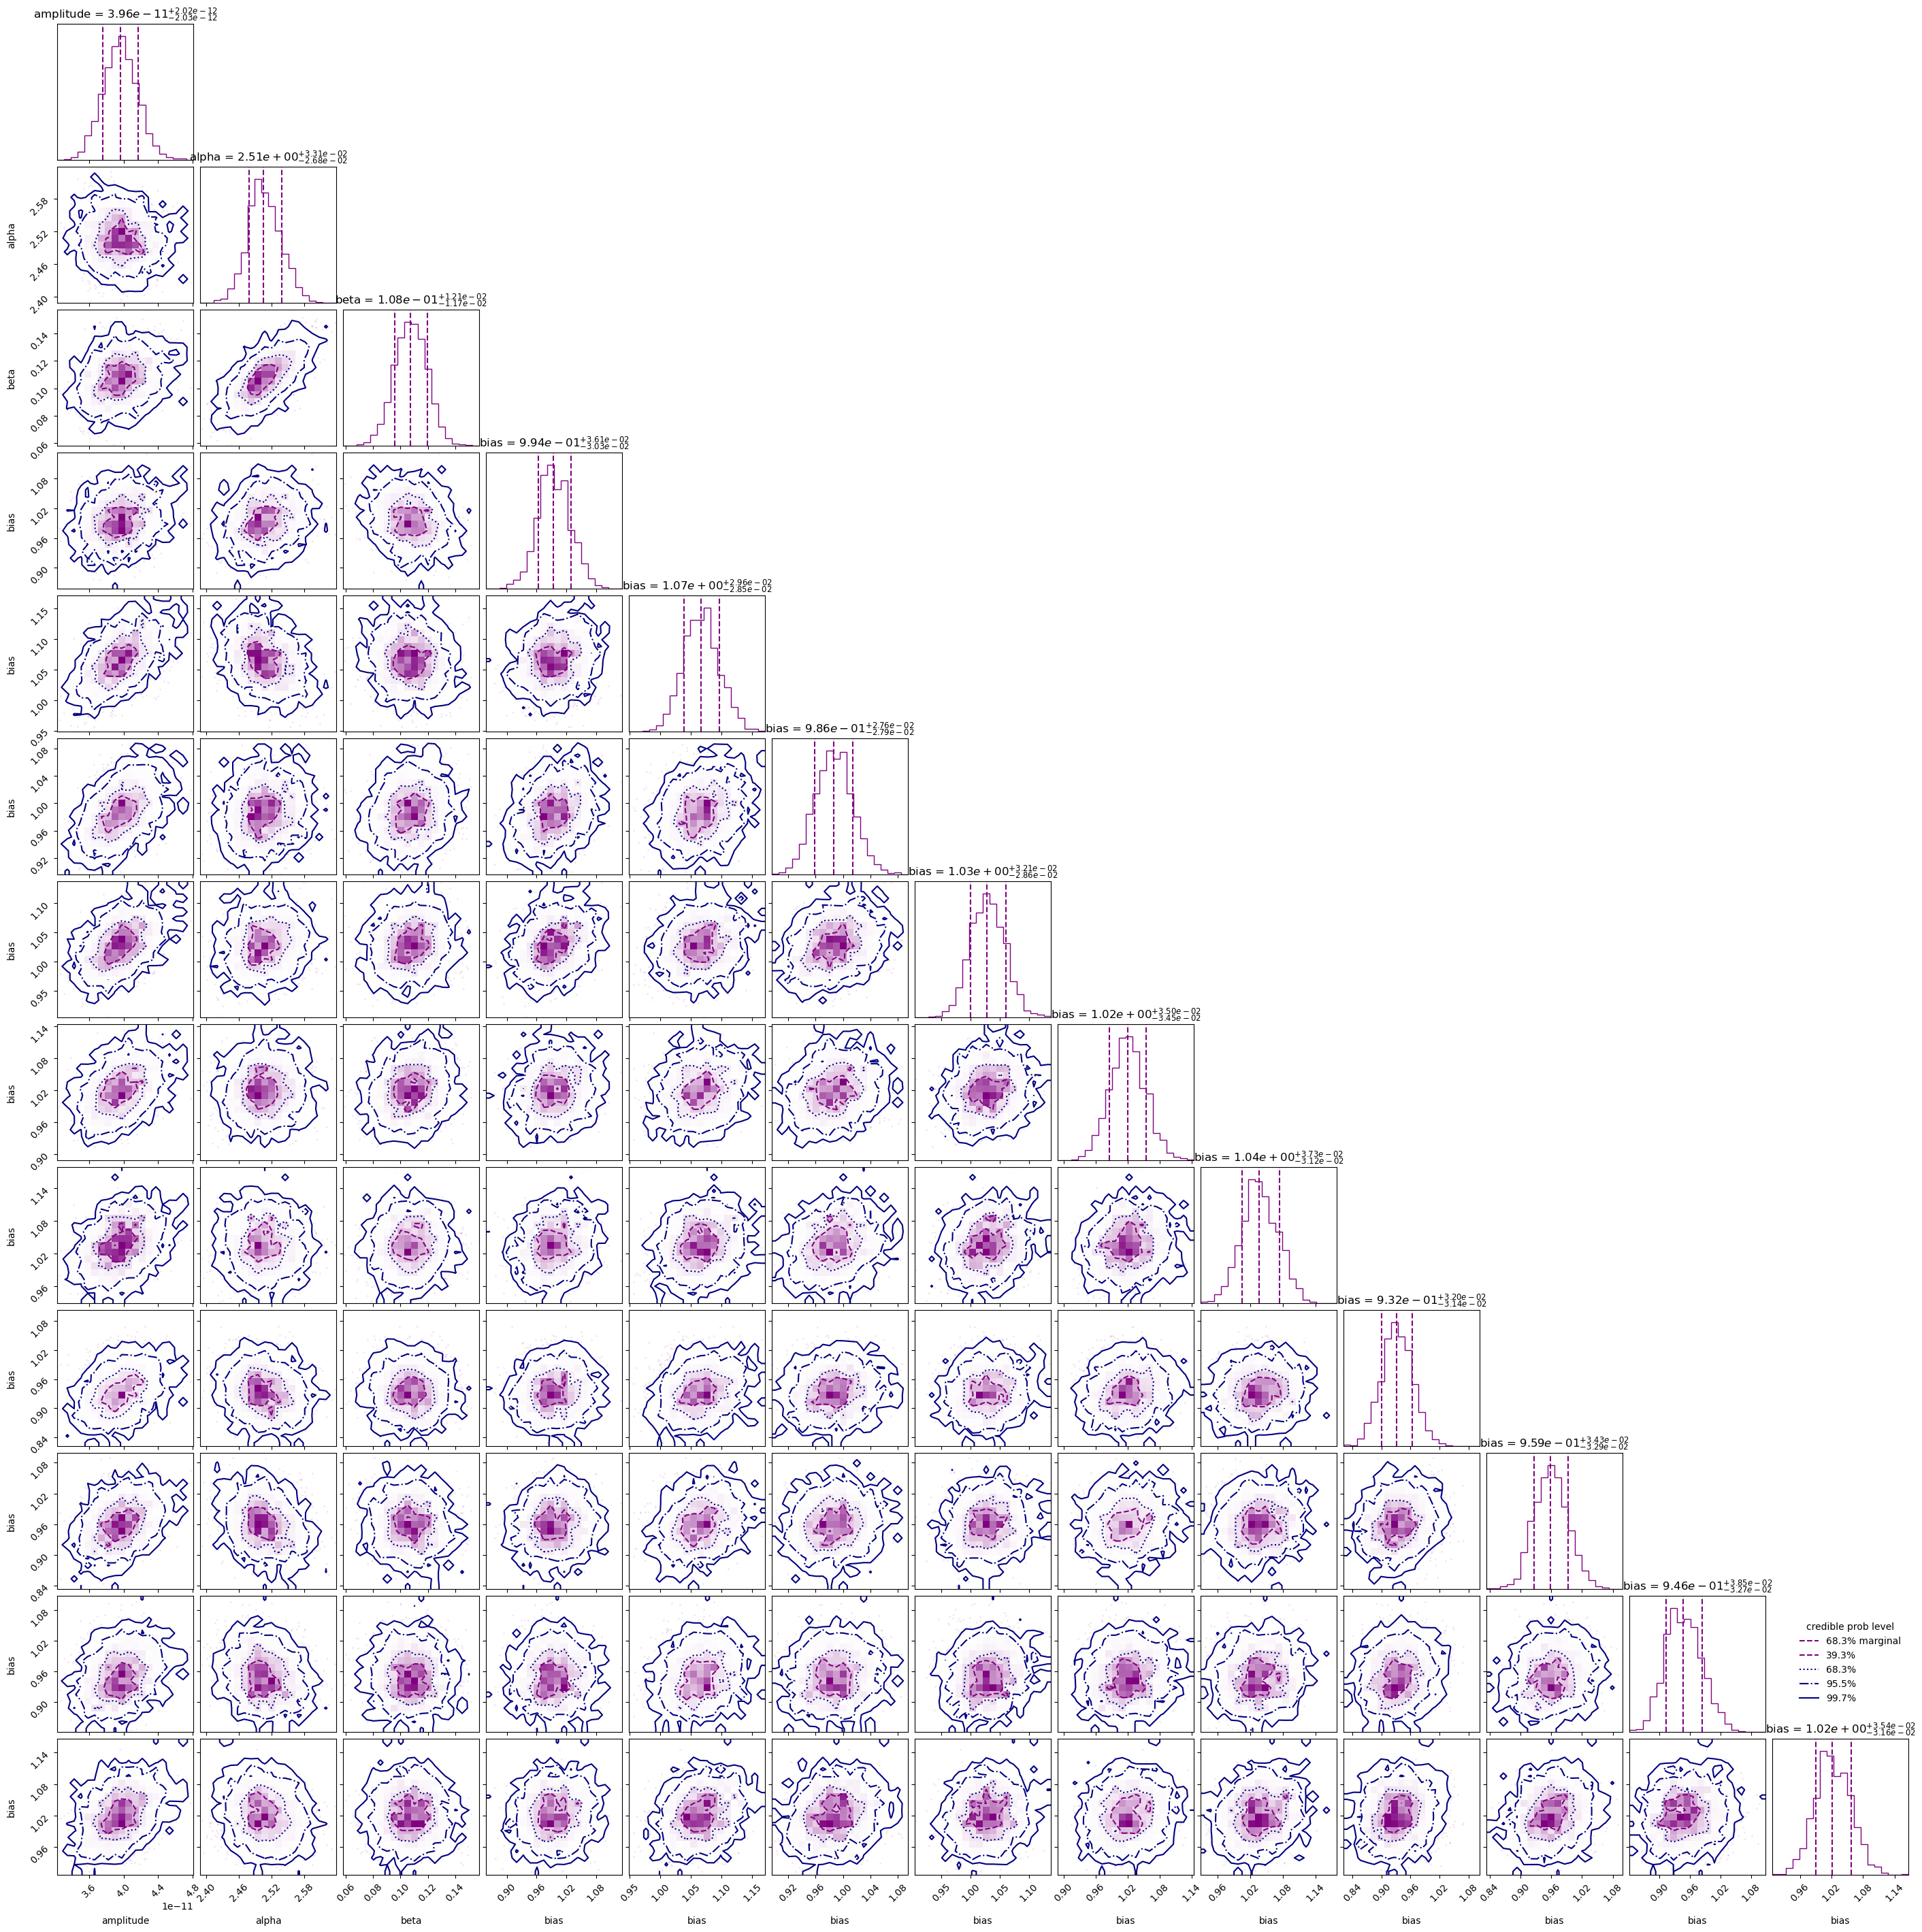

In [33]:
from ultranest.plot import cornerplot

cornerplot(
    sample_results.sampler_results,
    plot_datapoints=True,
    plot_density=True,
    bins=20,
    title_fmt=".2e",
    smooth=False,
)
plt.show()